In [1]:
# General Packages
import math
import os
from pathlib import Path

# data handling libraries
import pandas as pd
import numpy as np
from tabulate import tabulate

# visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns

# extra libraries
import warnings
warnings.filterwarnings('ignore')

# Packages to support NN

# sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#tensorflow
import tensorflow as tf
from tensorflow import keras

# Keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense

from rich.progress import Progress
import time

In [2]:
# Function to evaluate predicted vs test data categorical variables
def plot_prediction_vs_test_categorical(y_test, y_pred, class_labels):
    # Plots the prediction vs test data for categorical variables.

    # Args:
    #     y_test (array-like): True labels of the test data.
    #     y_pred (array-like): Predicted labels of the test data.
    #     class_labels (list): List of class labels.

    # Create a confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Calculates performance of multivariate classification model
def calculate_performance_multiclass(y_true, y_pred):
    # Calculates various performance metrics for multiclass classification.

    # Args:
    #     y_true: The true labels.
    #     y_pred: The predicted labels.

    # Returns:
    #     A dictionary containing the calculated metrics.

    metrics = {}

    # Accuracy
    metrics['accuracy'] = accuracy_score(y_true, y_pred)

    # Precision, Recall, and F1-score (macro-averaged)
    metrics['precision'] = precision_score(y_true, y_pred, average='macro')
    metrics['recall'] = recall_score(y_true, y_pred, average='macro')
    metrics['f1_score'] = f1_score(y_true, y_pred, average='macro')

    # Confusion Matrix
    metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred)

    return metrics

In [6]:
# load training data from current dir
current_dir = os.getcwd()

file_path = os.path.join(current_dir, "new_training_andy.csv")

df = pd.read_csv(file_path)

# lines below are to clean the data 
# Mocodes used to crash the program but need to try again and see if it does
#df = df.drop('DATE OCC', axis=1)
#df = df.drop('TIME OCC', axis=1)
#df = df.drop('Mocodes', axis=1)

# drop where status == CC 
# there are only 2 CC in the entire training file
#df = df[df['Status'] != 'CC']

#df.to_csv('new_training_andy.csv', index=False)

print((df.Status == "IC").sum())
print((df.Status == "AA").sum())
print((df.Status == "AO").sum())
print((df.Status == "JO").sum())
print((df.Status == "JA").sum())


print(df.info())

189912
17702
28267
589
774
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237244 entries, 0 to 237243
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   AREA            237244 non-null  int64  
 1   Crm Cd          237244 non-null  int64  
 2   Vict Age        237244 non-null  int64  
 3   Vict Sex        237244 non-null  object 
 4   Vict Descent    237244 non-null  object 
 5   Premis Cd       237244 non-null  float64
 6   Weapon Used Cd  237244 non-null  float64
 7   Status          237244 non-null  object 
 8   Target          237244 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 16.3+ MB
None


In [8]:
# load testing data from current dir
current_dir = os.getcwd()

file_path = os.path.join(current_dir, "new_testing_andy.csv")

df2 = pd.read_csv(file_path)

print(df2.info())

# do the same cleaning as the training
#df2 = df2.drop('DATE OCC', axis=1)
#df2 = df2.drop('TIME OCC', axis=1)
#df2 = df2.drop('Mocodes', axis=1)

#df2.to_csv('new_testing_andy.csv', index=False)

print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44930 entries, 0 to 44929
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DATE OCC        44930 non-null  object 
 1   TIME OCC        44930 non-null  object 
 2   AREA            44930 non-null  int64  
 3   Crm Cd          44930 non-null  int64  
 4   Mocodes         44930 non-null  object 
 5   Vict Age        44930 non-null  int64  
 6   Vict Sex        44930 non-null  object 
 7   Vict Descent    44930 non-null  object 
 8   Premis Cd       44930 non-null  float64
 9   Weapon Used Cd  44930 non-null  float64
 10  Status          44930 non-null  object 
 11  Target          44930 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44930 entries, 0 to 44929
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  ---

In [9]:
# set variables for model
target = ['Status']
numerical = ['AREA', 'Crm Cd', 'Vict Age', 'Premis Cd', 'Weapon Used Cd']
# uses too much memory when Mocodes is used but would like to include it
categorical = ['Target', 'Vict Sex', 'Vict Descent']

In [10]:
# set up encoder
encoder = OneHotEncoder(handle_unknown='ignore')

le = LabelEncoder()

In [11]:
# encoding categorical values for training
encoded_features = encoder.fit_transform(df[categorical])

# convert encoded data to a dataframe
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out(categorical))

# combine dataframes
df = pd.concat([df, encoded_df], axis=1)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237244 entries, 0 to 237243
Data columns (total 32 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   AREA              237244 non-null  int64  
 1   Crm Cd            237244 non-null  int64  
 2   Vict Age          237244 non-null  int64  
 3   Vict Sex          237244 non-null  object 
 4   Vict Descent      237244 non-null  object 
 5   Premis Cd         237244 non-null  float64
 6   Weapon Used Cd    237244 non-null  float64
 7   Status            237244 non-null  object 
 8   Target            237244 non-null  object 
 9   Target_Arrest     237244 non-null  float64
 10  Target_No Arrest  237244 non-null  float64
 11  Vict Sex_F        237244 non-null  float64
 12  Vict Sex_M        237244 non-null  float64
 13  Vict Descent_A    237244 non-null  float64
 14  Vict Descent_B    237244 non-null  float64
 15  Vict Descent_C    237244 non-null  float64
 16  Vict Descent_D    23

In [12]:
# encoding categorical values for testing
encoded_features2 = encoder.fit_transform(df2[categorical])

# convert encoded data to a dataframe
encoded_df2 = pd.DataFrame(encoded_features2.toarray(), columns=encoder.get_feature_names_out(categorical))

# combine dataframes
df2 = pd.concat([df2, encoded_df2], axis=1)

print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44930 entries, 0 to 44929
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DATE OCC          44930 non-null  object 
 1   TIME OCC          44930 non-null  object 
 2   AREA              44930 non-null  int64  
 3   Crm Cd            44930 non-null  int64  
 4   Mocodes           44930 non-null  object 
 5   Vict Age          44930 non-null  int64  
 6   Vict Sex          44930 non-null  object 
 7   Vict Descent      44930 non-null  object 
 8   Premis Cd         44930 non-null  float64
 9   Weapon Used Cd    44930 non-null  float64
 10  Status            44930 non-null  object 
 11  Target            44930 non-null  object 
 12  Target_Arrest     44930 non-null  float64
 13  Target_No Arrest  44930 non-null  float64
 14  Vict Sex_F        44930 non-null  float64
 15  Vict Sex_M        44930 non-null  float64
 16  Vict Descent_A    44930 non-null  float6

In [13]:
#handle the target for training 
encoded_target = encoder.fit_transform(df[target])

encoded_target_df = pd.DataFrame(encoded_target.toarray(), columns=encoder.get_feature_names_out(target))

df = pd.concat([df, encoded_target_df], axis=1)

print(df.info())

[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237244 entries, 0 to 237243
Data columns (total 37 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   AREA              237244 non-null  int64  
 1   Crm Cd            237244 non-null  int64  
 2   Vict Age          237244 non-null  int64  
 3   Vict Sex          237244 non-null  object 
 4   Vict Descent      237244 non-null  object 
 5   Premis Cd         237244 non-null  float64
 6   Weapon Used Cd    237244 non-null  float64
 7   Status            237244 non-null  object 
 8   Target            237244 non-null  object 
 9   Target_Arrest     237244 non-null  float64
 10  Target_No Arrest  237244 non-null  float64
 11  Vict Sex_F        237244 non-null  float64
 12  Vict Sex_M        237244 non-null  float64
 13  Vict Descent_A    237244 non-null  float64
 14  Vi

In [14]:
#handle the target for testing

encoded_target2 = encoder.fit_transform(df2[target])

encoded_target_df2 = pd.DataFrame(encoded_target2.toarray(), columns=encoder.get_feature_names_out(target))

df2 = pd.concat([df2, encoded_target_df2], axis=1)

print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44930 entries, 0 to 44929
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DATE OCC          44930 non-null  object 
 1   TIME OCC          44930 non-null  object 
 2   AREA              44930 non-null  int64  
 3   Crm Cd            44930 non-null  int64  
 4   Mocodes           44930 non-null  object 
 5   Vict Age          44930 non-null  int64  
 6   Vict Sex          44930 non-null  object 
 7   Vict Descent      44930 non-null  object 
 8   Premis Cd         44930 non-null  float64
 9   Weapon Used Cd    44930 non-null  float64
 10  Status            44930 non-null  object 
 11  Target            44930 non-null  object 
 12  Target_Arrest     44930 non-null  float64
 13  Target_No Arrest  44930 non-null  float64
 14  Vict Sex_F        44930 non-null  float64
 15  Vict Sex_M        44930 non-null  float64
 16  Vict Descent_A    44930 non-null  float6

In [15]:
# set up dataframe for model

features_in_model = ["AREA", "Crm Cd", "Vict Age", "Vict Sex", "Vict Descent", 
                     "Premis Cd", "Weapon Used Cd", "Status", "Target", "Target_Arrest", "Target_No Arrest",
                     "Vict Sex_F", "Vict Sex_M", "Vict Descent_A", "Vict Descent_B", "Vict Descent_C", 
                     "Vict Descent_D", "Vict Descent_F", "Vict Descent_G", "Vict Descent_H", "Vict Descent_I", 
                     "Vict Descent_J", "Vict Descent_K", "Vict Descent_L", "Vict Descent_O", "Vict Descent_P", 
                     "Vict Descent_S", "Vict Descent_U", "Vict Descent_V", "Vict Descent_W", "Vict Descent_X", 
                     "Vict Descent_Z"]

target_features = ["Status_AA", "Status_AO", "Status_IC", "Status_JA", "Status_JO"]

# Getting the size of input size
print(len(features_in_model))


32


In [16]:
# data sets for the training
X = encoded_features.toarray()
Y = encoded_target.toarray()

print(X.shape)
print(Y.shape)

(237244, 23)
(237244, 5)


In [17]:
# data sets for the testing
X_test = encoded_features2.toarray()
Y_test = encoded_target2.toarray()

print(X_test.shape)
print(Y_test.shape)

(44930, 23)
(44930, 5)


In [18]:
# set up neural network
model = keras.Sequential()

# Adding input model --> 32 input layers
model.add(Dense(32, input_dim = X.shape[1], activation = 'relu'))

# Adding hidden layer 
model.add(keras.layers.Dense(48, activation="relu"))
model.add(keras.layers.Dense(96, activation="relu"))
model.add(keras.layers.Dense(96, activation="relu"))
model.add(keras.layers.Dense(48, activation="relu"))

# For classification tasks, we generally tend to add an activation function in the output ("sigmoid" for binary, and "softmax" for multi-class, etc.).
model.add(keras.layers.Dense(5, activation="softmax"))

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 48)                  │           1,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 96)                  │           4,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 96)                  │           9,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 48)                  │           4,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             245 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,269 (83.08 KB)

 Trainable params: 21,269 (83.08 KB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
# compile the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [20]:
# train the model
model.fit(X, Y, epochs = 12, batch_size = 32)

Epoch 1/12
7414/7414 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.8704 - loss: 0.4044
Epoch 2/12
7414/7414 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.8753 - loss: 0.3762
Epoch 3/12
7414/7414 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.8753 - loss: 0.3746
Epoch 4/12
7414/7414 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.8752 - loss: 0.3745
Epoch 5/12
7414/7414 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - accuracy: 0.8745 - loss: 0.3760
Epoch 6/12
7414/7414 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.8746 - loss: 0.3757
Epoch 7/12
7414/7414 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.8749 - loss: 0.3749
Epoch 8/12
7414/7414 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.8753 - loss: 0.3745
Epoch 9/12
7414/7414 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.8753 - loss: 0.3744
Epoch 10/12
7414/7414 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.8756 - loss: 0.3742
Epoch 11/12
7414/7414 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.8756 - loss: 0.3741
Epoch 12/12
7414/74

In [21]:
#Evaluate accuracy
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nLoss:', test_loss)

1405/1405 - 6s - 4ms/step - accuracy: 0.9116 - loss: 0.3061

Test accuracy: 0.9115735292434692

Loss: 0.3060839772224426


In [22]:
# Make Predictions
predictions = model.predict(X_test)

# Here, the model has predicted the label for each image in the testing set. Let's take a look at some predictions
print(predictions[0])
print(predictions[10])
print(predictions[100])
print(predictions[1000])
print(predictions[10000])

1405/1405 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
[2.1180533e-06 1.9189015e-01 8.0305350e-01 5.2897781e-07 5.0536324e-03]
[4.7655990e-10 1.6364990e-02 9.8350579e-01 1.8036697e-11 1.2917917e-04]
[9.2799804e-05 1.3164063e-01 8.6208564e-01 1.0197875e-05 6.1706943e-03]
[1.3356509e-06 9.0192527e-02 9.0803528e-01 1.5144329e-07 1.7707001e-03]
[8.4638003e-07 1.2511113e-01 8.7308896e-01 1.3893916e-07 1.7989572e-03]


In [23]:
# getting y_test values
y_tested = encoder.inverse_transform(Y_test)

# getting the value of the predictions
y_predicted = encoder.inverse_transform(predictions)

# printing the first 30 values of the test and predicted values 
data = []
for i in range(50):
    data.append([y_tested[i], y_predicted[i]])

headers = ["True Value", "Predicted Value"]

print(tabulate(data, headers=headers, tablefmt="grid"))

+--------------+-------------------+
| True Value   | Predicted Value   |
+==============+===================+
| ['IC']       | ['IC']            |
+--------------+-------------------+
| ['IC']       | ['IC']            |
+--------------+-------------------+
| ['IC']       | ['IC']            |
+--------------+-------------------+
| ['IC']       | ['IC']            |
+--------------+-------------------+
| ['IC']       | ['IC']            |
+--------------+-------------------+
| ['IC']       | ['IC']            |
+--------------+-------------------+
| ['IC']       | ['IC']            |
+--------------+-------------------+
| ['IC']       | ['IC']            |
+--------------+-------------------+
| ['IC']       | ['IC']            |
+--------------+-------------------+
| ['IC']       | ['IC']            |
+--------------+-------------------+
| ['IC']       | ['IC']            |
+--------------+-------------------+
| ['IC']       | ['IC']            |
+--------------+-------------------+
|

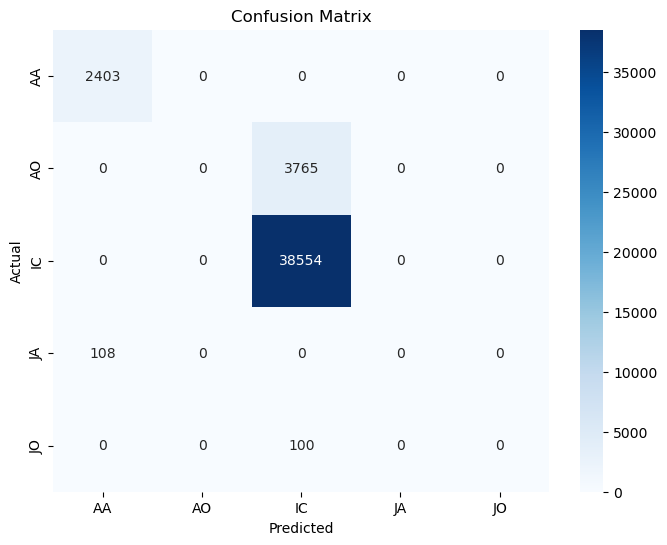

In [24]:
# Confusion Matrix
# Class labels
class_labels=['AA', 'AO', 'IC', 'JA', 'JO']

plot_prediction_vs_test_categorical(y_tested, y_predicted, class_labels)